# Agenda
- Analyze the [Car Price ](https://www.kaggle.com/goyalshalini93/car-price-prediction-linear-regression-rfe/data) dataset and answer the following possible questions that may arise :
	#### I. Exploratory Data Analysis. (Optional)
	_(*Optional, you can move to regression modelling if you want)_
		1. Plot out the correlation matrix using seaborn's heatmap function and find out top 5 most correlated features with car prices.
		2. What car brands are the most common? (Count the number of cars by the brand name).
		3. What type of fuel is more common ? Diesel or gas? Support the answer with an appropriate visualization.
		4. Find out the average car prices by companies. (Group the dataset by company name and average out the price).

	#### II. Regression modelling.
		1. Choose some features to model the regression model.
		2. Separate the dataset into training set and testing set (train_test_split from sklearn model_selection module).
		3. Train a linear regression model on the train dataset.
		4. Evaluate the model : Calculate the R2 score and the root mean squared error using the test dataset.
		5. (Optional) Train a decision tree and perform the same evaluation step you did with linear regression.

# Dataset description
- This dataset consists of two files : 
	- 1. **CarPrice_Assignment.csv** : Dataset file.
	- 2. **Data Dictionary - carprices.xlsx** : Columns description.
- The dataset contains 205 records about the features associated to automobiles from multiple brands like fuel types, number of doors, wheel base, ...

# Recommended reading
- Linear regression comprehensively explained : [StatQuest](https://www.youtube.com/watch?v=nk2CQITm_eo)
- Decision tree for regression explained : [StatQuest](https://www.youtube.com/watch?v=g9c66TUylZ4&t=143s)
- Feature selection with recursive features elimination (RFE) : [Sklearn Doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

# Import libraries

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Import dataset
data = pd.read_csv('CarPrice_Assignment.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

## I. Exploratory Data Analysis

### Question 1 : Correlation matrix

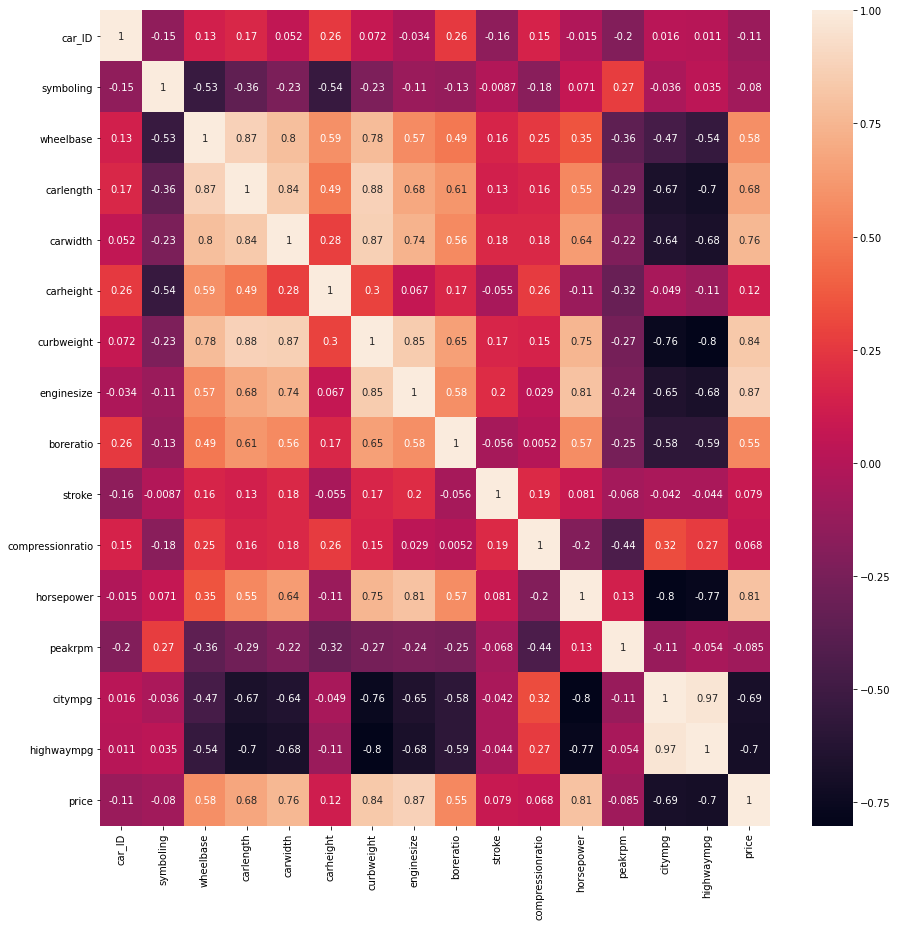

In [47]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Create matplotlib figure and axes 
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the correlation matrix with sns.heatmap
sns.heatmap(corr_matrix, annot=True, ax=ax)

plt.show()

In [48]:
# Get the column of the target (price) in the correlation matrix
price_corr = corr_matrix['price']

# Convert all correlation to absolute values
price_corr = price_corr.apply(lambda x : abs(x))

# Sort the correlation in ascending order
price_corr = price_corr.sort_values()

# Get the top 5 correlated features, excluding the target itself
price_corr[-6:-1]

highwaympg    0.697599
carwidth      0.759325
horsepower    0.808139
curbweight    0.835305
enginesize    0.874145
Name: price, dtype: float64

### Question 2 : Most common car brands

In [49]:
# Since the brand name is in the first word of the car name. We extract the first word
# in the car name to get car brand
data['Brand'] = data['CarName'].apply(lambda x : x.split(' ')[0])

# Get different brand names
data['Brand'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

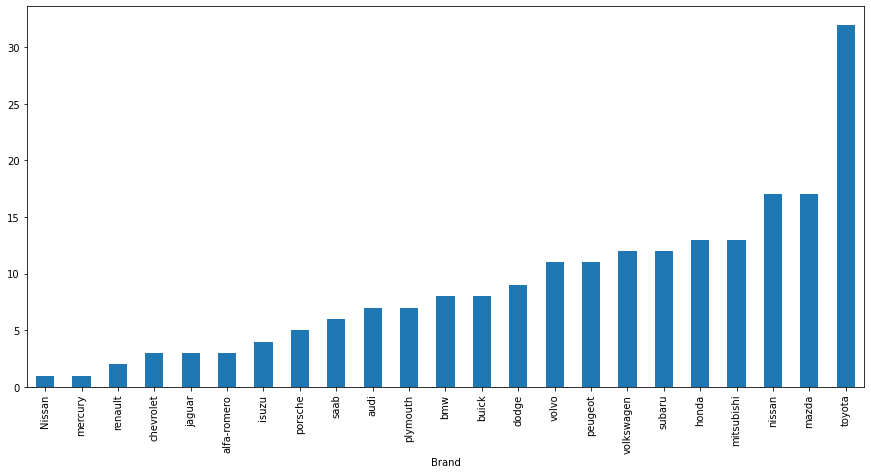

In [50]:
# Got some error in brand names. E.g : mazda -> maxda, toyota -> toyouta.
# Gotta clean them up
def clean_brand_name(s):
    if(s == 'maxda'): return 'mazda'
    if(s == 'porcshce') : return 'porsche'
    if(s == 'toyouta') : return 'toyota'
    if(s == 'vokswagen' or s == 'vw') : return 'volkswagen'
    else : return s

# Apply the clean function to Brand column
data['Brand'] = data['Brand'].apply(clean_brand_name)
    
# Count number of cars by brand
fig, ax = plt.subplots(figsize=(15, 7))
data.groupby('Brand').count()['car_ID'].sort_values().plot(kind='bar')

plt.show()

### Question 3 : More common fuel type

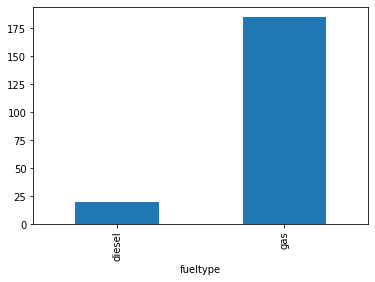

In [51]:
data.groupby('fueltype').count()['car_ID'].plot(kind='bar')
plt.show()

### Question 4 : Average car price by companies

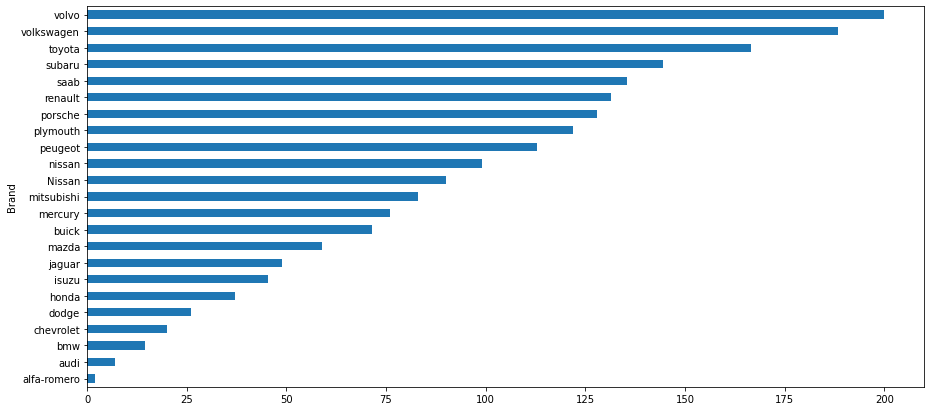

In [52]:
# Make use of the Brand column again and groupby Brand, then average 
fig, ax = plt.subplots(figsize=(15, 7))
data.groupby('Brand').mean()['car_ID'].sort_values().plot.barh()

plt.show()

## II. Regression modelling

### 1. Feature selection 
* For this one I will use RFE since last time you guys did not use it as often.

In [57]:
# Convert all object type columns to numeric
obj_columns = data.select_dtypes('object').columns
for col in obj_columns:
    data[col] = OrdinalEncoder().fit_transform(data[[col]])

In [66]:
# Separate the features and the targets
# Get all columns
feature_columns = list(data.columns)
feature_columns.remove('price')
feature_columns.remove('car_ID') # It does not make sense that car id is a feature

features = data[feature_columns]
targets = data['price']

# Create an estimator as a pivot to select features - I will choose decision tree so I don't have to 
# Preprocess the data
estimator = DecisionTreeRegressor()
selector = RFE(estimator, n_features_to_select=6, step=1) # Select 6 features
selector = selector.fit(features, targets)

In [67]:
# The columns that are marked True in support_ are the chosen columns
print(data.columns)
print(selector.support_)

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price', 'Brand'],
      dtype='object')
[False  True False False False False False False False False  True False
  True False False  True False False False False  True False False  True
 False]


In [70]:
selected = []
for col, support in zip(data.columns, selector.support_):
    if(support):
        selected.append(col)
selected

['symboling',
 'carlength',
 'carheight',
 'cylindernumber',
 'compressionratio',
 'citympg']

In [71]:
# Get the features as the selected features
features = data[selected]

### 2. Separate the dataset


In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.2)

### 3. Train a linear regression model

In [73]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### 4. Evaluate the model

In [74]:
# Make prediction on test set
predictions = model.predict(X_test)

# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
r2 = r2_score(Y_test, predictions)

# Print it out
print(f'RMSE = {rmse}')
print(f'R2 score = {r2}')

RMSE = 4861.716398944507
R2 score = 0.6282506910625603


### 5. Train a decision tree

In [75]:
model = DecisionTreeRegressor(min_samples_leaf=5)
model.fit(X_train, Y_train)

# Make prediction on test set
predictions = model.predict(X_test)

# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
r2 = r2_score(Y_test, predictions)

# Print it out
print(f'RMSE = {rmse}')
print(f'R2 score = {r2}')

RMSE = 3278.7918436879554
R2 score = 0.8309175160340123
